In [19]:
from data_loader import load_ticker
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [20]:
date, adj_close = load_ticker()
print('Date:\n', date)
print('Adjusted Close\n', adj_close)

Date:
 ['1927-12-30T00:00:00.000000000' '1928-01-03T00:00:00.000000000'
 '1928-01-04T00:00:00.000000000' ... '2024-12-18T00:00:00.000000000'
 '2024-12-19T00:00:00.000000000' '2024-12-20T00:00:00.000000000']
Adjusted Close
 [  17.65999985   17.76000023   17.71999931 ... 5872.16015625 5867.08007812
 5930.85009766]


In [21]:
# Split data into train and test
n = len(date)
train_n = int(0.8 * n)
test_n = n - train_n
x_train, y_train = date[:train_n], adj_close[:train_n]
x_test, y_test = date[train_n:], adj_close[train_n:]

In [22]:
# Convert datetime arrays into numerical features
x_train = pd.to_datetime(x_train)
x_test = pd.to_datetime(x_test)
x_train_datetime, x_test_datetime = x_train.copy(), x_test.copy()

def datetime_features(datetime_series):
    return np.stack(
        [
            datetime_series.year,
            datetime_series.month,
            datetime_series.day,
            datetime_series.hour,
            datetime_series.minute,
            datetime_series.second,
        ],
        axis=1,
    )

x_train = datetime_features(x_train)
x_test = datetime_features(x_test)

In [23]:
# Normalize features and stock prices
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)

y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test = scaler_y.transform(y_test.reshape(-1, 1))

In [24]:
def smooth_data(data, window_size=5):
    return np.convolve(data.flatten(), np.ones(window_size) / window_size, mode='same')

y_train = smooth_data(y_train)
y_test = smooth_data(y_test)

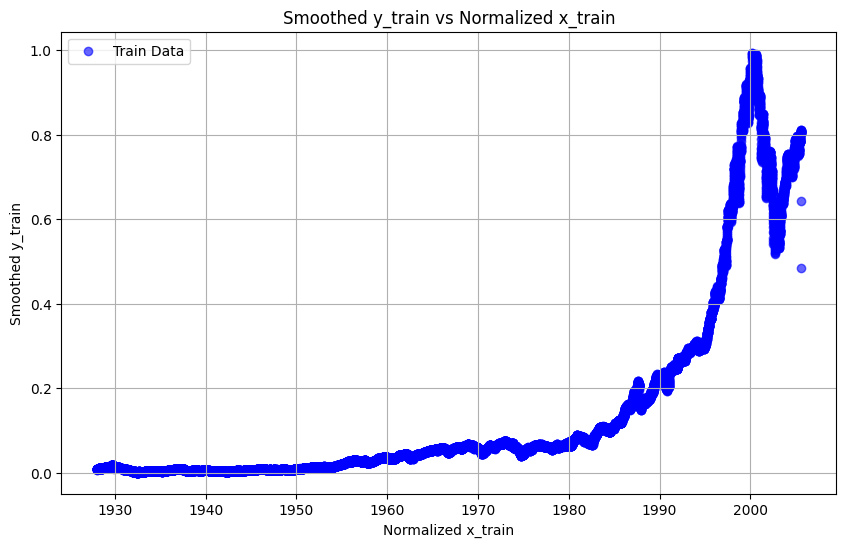

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(x_train_datetime, y_train, color='blue', label='Train Data', alpha=0.6)
plt.title('Smoothed y_train vs Normalized x_train')
plt.xlabel('Normalized x_train')
plt.ylabel('Smoothed y_train')
plt.legend()
plt.grid()
plt.show()

In [27]:
def create_sequences(x, y, sequence_length=10):
    x_seq, y_seq = [], []
    for i in range(len(x) - sequence_length):
        x_seq.append(x[i : i + sequence_length])
        y_seq.append(y[i + sequence_length])
    return np.array(x_seq), np.array(y_seq)

sequence_length = 10

x_train_seq, y_train_seq = create_sequences(x_train, y_train, sequence_length)
x_test_seq, y_test_seq = create_sequences(x_test, y_test, sequence_length)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(x_train_seq.shape[1], x_train_seq.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(x_train_seq, y_train_seq, epochs=50, batch_size=32, validation_data=(x_test_seq, y_test_seq))

In [ ]:
# Make predictions
y_pred = model.predict(x_test_seq)

# Reverse scaling for predictions and actual values
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test_seq)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.legend()
plt.show()